In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs, pad_seqs

In [2]:
def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

# RNN

In [3]:
num_classes = 14
batchsize=25
# specs
input_size = num_classes
output_size = 1
hidden_size = 20
num_layers = 1
learningRate = 0.005


In [21]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]


def train(sequence,label,model,optimizer,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()


def run(model, train_data, epochs):

    model.train()
    loss_history = []
    for epoch in range(epochs):
        lossTotal = 0
        for x,y in train_data:
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history.append(lossTotal)

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
            if (epoch%100 == 2):
                if i%50 == 0:
                    if verbose:
                        print('\n################\nepoch: ',epoch, '\n################\n')
                        print('output =. ' , output.detach().numpy())
                        print('label =. ' , y.detach().numpy())
                        test_acc(model, test_data, hidden_size, verbose = True)
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

# def run_sim(i):
#     print('########## rep ', i, '##########')
#     model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
#     loss1, acc1 = run_acc(model,optimizer,criterion, trainset[0], test_sets, epochs)
#     loss2, acc2 = run_acc(model,optimizer,criterion, trainset[1], test_sets, epochs)
#     losses = loss1+loss2
#     accs = np.vstack([acc1,acc2])
#     return losses, accs

def run_sim(i):
    print('########## rep ', i, '##########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset[0], test_sets, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, trainset[1], test_sets, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])

    return losses, accs, model


def seq_acc(model, testset, hidden_size, rep = 10, verbose = False):
    
    train_inputs = convert_seq2inputs(testset, num_classes=num_classes, seq_len=8)
    testdata = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
    model.eval()
    trials = []
    accs = []
    for _ in range(rep):
        for j, (x,y) in enumerate(testdata):
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item() 
                accs.append(float(correct))
                curr_trial = testset[4*j+i].copy()
                trials.append([x for x in curr_trial if x!= ('X', 'X')])
#                 trials.append(curr_trial)
    
    df = pd.DataFrame({'trial':trials, 'acc':accs})
    df['trial'] = df['trial'].apply(str)
    df = df.groupby(['trial']).mean().sort_values(by = 'acc', ascending=False)
                
    return df 

# Load Data

In [11]:
os.listdir('../sequences/pretraining/')

['type1', 'type2_12', 'type2_48', 'type5', 'type3', 'type4', 'type2_3']

In [47]:
pretrainpath = '../sequences/pretraining/'

with open(pretrainpath+'type4_all', 'rb') as f:
    type4_all = pickle.load(f)
with open(pretrainpath+'type4', 'rb') as f:
    type4 = pickle.load(f)
with open(pretrainpath+'type5', 'rb') as f:
    type5 = pickle.load(f)

# Load Training and Test data
trianpath = '../sequences/training/'

#Mset
with open(trianpath + 'Mset', 'rb') as f:
    Mset = pickle.load(f)
with open(trianpath + 'Mtest_combos', 'rb') as f:
    Mtest_combos = pickle.load(f)
with open(trianpath + 'Mtest_order', 'rb') as f:
    Mtest_order = pickle.load(f)
with open(trianpath + 'Mtest_init', 'rb') as f:
    Mtest_init = pickle.load(f)

# MC set
with open(trianpath + 'MCset', 'rb') as f:
    MCset = pickle.load(f)
with open(trianpath + 'MCtest_order', 'rb') as f:
    MCtest_order = pickle.load(f)
with open(trianpath + 'MCtest_init', 'rb') as f:
    MCtest_init = pickle.load(f)
    
# DC set
with open(trianpath + 'DCset', 'rb') as f:
    DCset = pickle.load(f)
with open(trianpath + 'DCtest_order', 'rb') as f:
    DCtest_order = pickle.load(f)
with open(trianpath + 'DCtest_init', 'rb') as f:
    DCtest_init = pickle.load(f)

# F set
with open(trianpath + 'Fset', 'rb') as f:
    Fset = pickle.load(f)
with open(trianpath + 'Fset_init_small', 'rb') as f:
    Ftest_init = pickle.load(f)

# Train/test Sequences

In [48]:
# convert sequences to inputs 

# Pretraining

# train_inputs = convert_seq2inputs(type3, num_classes=num_classes, seq_len=7)
# T3 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(type4, num_classes=num_classes, seq_len=7)
T4 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(type4_all, num_classes=num_classes, seq_len=7)
T4a = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(type5, num_classes=num_classes, seq_len=7)
T5 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)


# Mset
train_inputs = convert_seq2inputs(Mset, num_classes=num_classes, seq_len=7)
trainMset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Mtest_combos, num_classes=num_classes, seq_len=7)
trainMtest_combos = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Mtest_order, num_classes=num_classes, seq_len=7)
trainMtest_order = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Mtest_init, num_classes=num_classes, seq_len=7)
trainMtest_init = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# MCaset
train_inputs = convert_seq2inputs(MCset, num_classes=num_classes, seq_len=7)
trainMCset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(MCtest_order, num_classes=num_classes, seq_len=7)
trainMCtest_order = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(MCtest_init, num_classes=num_classes, seq_len=7)
trainMCtest_init = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# DCaset
train_inputs = convert_seq2inputs(DCset, num_classes=num_classes, seq_len=7)
trainDCset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(DCtest_order, num_classes=num_classes, seq_len=7)
trainDCtest_order = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(DCtest_init, num_classes=num_classes, seq_len=7)
trainDCtest_init = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# Fset
train_inputs = convert_seq2inputs(Fset, num_classes=num_classes, seq_len=7)
trainFset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Ftest_init, num_classes=num_classes, seq_len=7)
trainFtest_init = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)


# Train

Accuracy plots. 
Table of trials.
Have a shuffled RNN as reference

P3
1. MC
2. DC
3. F

P12
1. MC
2. DC
3. F

P48
1. MC
2. DC
3. F

In [24]:
num_sims = 10
epochs = 500
learningRate = 0.005

# T4

In [49]:
########### Mset
trainset = [T4a, trainMset]
test_sets = [trainMset, trainMtest_combos, trainMtest_order, trainMtest_init]
t1 = time.time()
T4a_Mres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

T4a_Mlosses = np.hstack([T4a_Mres[i][0] for i in range(len(T4a_Mres))])
T4a_Macc_train = np.array([T4a_Mres[i][1][:,0] for i in range(len(T4a_Mres))]).T
T4a_Macc_combos = np.array([T4a_Mres[i][1][:,1] for i in range(len(T4a_Mres))]).T
T4a_Macc_order = np.array([T4a_Mres[i][1][:,2] for i in range(len(T4a_Mres))]).T
T4a_Macc_init = np.array([T4a_Mres[i][1][:,3] for i in range(len(T4a_Mres))]).T


time:  3.357274615764618


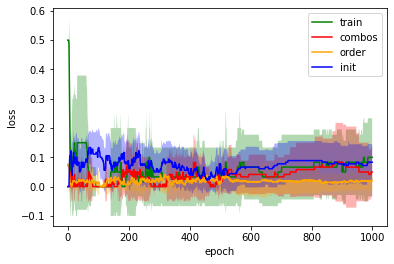

In [51]:
NNplt.plotNN_shifted([T4_Macc_train, T4_Macc_combos, T4_Macc_order, T4_Macc_init],\
                    labels = ['train', 'combos','order','init'],\
                    colors = ['green','red', 'orange', 'blue'],\
                    shift = 0)

In [27]:
############### DC set
trainset = [T4, trainDCset]
test_sets = [trainDCset, trainDCtest_order, trainDCtest_init]
t1 = time.time()
T4_DCres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

T4_DClosses = np.hstack([T4_DCres[i][0] for i in range(len(T4_DCres))])
T4_DCacc_train = np.array([T4_DCres[i][1][:,0] for i in range(len(T4_DCres))]).T
T4_DCacc_order = np.array([T4_DCres[i][1][:,1] for i in range(len(T4_DCres))]).T
T4_DCacc_init = np.array([T4_DCres[i][1][:,2] for i in range(len(T4_DCres))]).T

time:  17.361236854394278


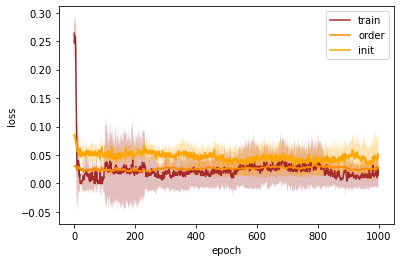

In [28]:
NNplt.plotNN_shifted([T4_DCacc_train, T4_DCacc_order, T4_DCacc_init],\
                    labels = ['train', 'order','init'],\
                    colors = ['brown','darkorange', 'orange'],\
                    shift = 0)
# NNplt.plotNN_shifted([P3_DCrand_acc_train, P3_DCrand_acc_order, P3_DCrand_acc_init],\
#                     labels = ['train', 'order','init'],\
#                     colors = ['aqua','darkblue', 'black'],\
#                     shift = epochs)

In [271]:
models = [res[i][4] for i in range(len(res))]
dfs = []
for model in models:
    df = seq_acc(model, DCset, hidden_size, rep = 50)
    dfs.append(df)


In [240]:
combos = []
for trial in DCset:
    combos += trial[1:-1]
    

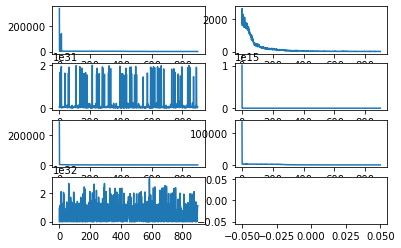

In [227]:
fig, axs = plt.subplots(4, 2)
for i in range(8):
    axs[math.floor(i/2), i%2].plot(rand_DC_loss[:,i])

In [31]:
############### `F set
trainset = [T4, trainFset]
test_sets = [trainDCset, trainFtest_init]
t1 = time.time()
T4_Fres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
# train on 1 position
t2 = time.time()
print('time: ', (t2-t1)/60)

T4_Flosses = np.hstack([T4_Fres[i][0] for i in range(len(T4_Fres))])
T4_Facc_train = np.array([T4_Fres[i][1][:,0] for i in range(len(T4_Fres))]).T
T4_Facc_test_init = np.array([T4_Fres[i][1][:,1] for i in range(len(T4_Fres))]).T


time:  14.195996916294098


# T5

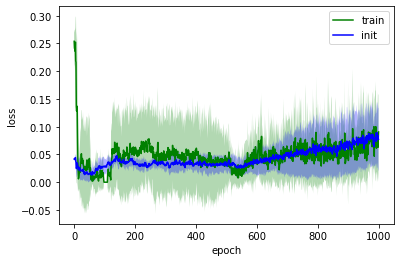

In [32]:
NNplt.plotNN_shifted([T4_Facc_train,T4_Facc_test_init],\
                    labels = ['train', 'init'],\
                    colors = ['green', 'blue'],\
                    shift = 0)


In [61]:
############### M set
trainset = [T5, trainMset]
test_sets = [trainMset, trainMtest_combos, trainMtest_order, trainMtest_init]
t1 = time.time()
T5_Mres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

T5_Mlosses = np.hstack([T5_Mres[i][0] for i in range(len(T5_Mres))])
T5_Macc_train = np.array([T5_Mres[i][1][:,0] for i in range(len(T5_Mres))]).T
T5_Macc_combos = np.array([T5_Mres[i][1][:,1] for i in range(len(T5_Mres))]).T
T5_Macc_order = np.array([T5_Mres[i][1][:,2] for i in range(len(T5_Mres))]).T
T5_Macc_init = np.array([T5_Mres[i][1][:,3] for i in range(len(T5_Mres))]).T

time:  4.334794350465139


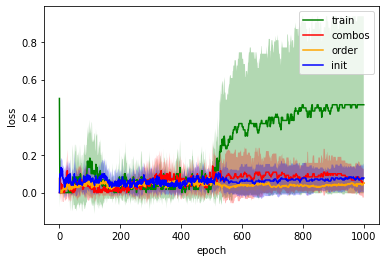

In [62]:
NNplt.plotNN_shifted([T5_Macc_train, T5_Macc_combos, T5_Macc_order, T5_Macc_init],\
                    labels = ['train', 'combos','order','init'],\
                    colors = ['green','red','orange', 'blue'],\
                    shift = 0)

In [56]:
############### MC set
trainset = [T5, trainMCset]
test_sets = [trainMCset, trainMCtest_order, trainMCtest_init]
t1 = time.time()
T5_MCres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

T5_MClosses = np.hstack([T5_MCres[i][0] for i in range(len(T5_MCres))])
T5_MCacc_train = np.array([T5_MCres[i][1][:,0] for i in range(len(T5_MCres))]).T
T5_MCacc_order = np.array([T5_MCres[i][1][:,1] for i in range(len(T5_MCres))]).T
T5_MCacc_init = np.array([T5_MCres[i][1][:,2] for i in range(len(T5_MCres))]).T

time:  16.150297300020853


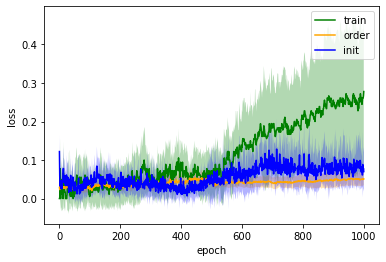

In [57]:
NNplt.plotNN_shifted([T5_MCacc_train, T5_MCacc_order, T5_MCacc_init],\
                    labels = ['train', 'order','init'],\
                    colors = ['green','orange', 'blue'],\
                    shift = 0)

In [38]:
############### DC set
trainset = [T5, trainDCset]
test_sets = [trainDCset, trainDCtest_order, trainDCtest_init]
t1 = time.time()
T5_DCres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

T5_DClosses = np.hstack([T5_DCres[i][0] for i in range(len(T5_DCres))])
T5_DCacc_train = np.array([T5_DCres[i][1][:,0] for i in range(len(T5_DCres))]).T
T5_DCacc_order = np.array([T5_DCres[i][1][:,1] for i in range(len(T5_DCres))]).T
T5_DCacc_init = np.array([T5_DCres[i][1][:,2] for i in range(len(T5_DCres))]).T

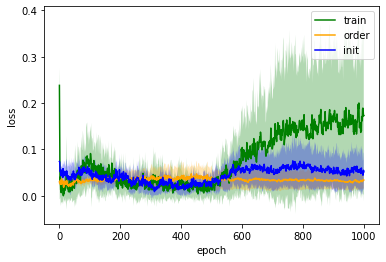

In [37]:
NNplt.plotNN_shifted([T5_DCacc_train, T5_DCacc_order, T5_DCacc_init],\
                    labels = ['train', 'order','init'],\
                    colors = ['green','orange', 'blue'],\
                    shift = 0)

In [29]:
############### `F set
trainset = [T5, trainFset]
test_sets = [trainDCset, trainFtest_init]
t1 = time.time()
T5_Fres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
# train on 1 position
t2 = time.time()
print('time: ', (t2-t1)/60)

T5_Flosses = np.hstack([T5_Fres[i][0] for i in range(len(T5_Fres))])
T5_Facc_train = np.array([T5_Fres[i][1][:,0] for i in range(len(T5_Fres))]).T
T5_Facc_test_init = np.array([T5_Fres[i][1][:,1] for i in range(len(T5_Fres))]).T


time:  18.3045193195343


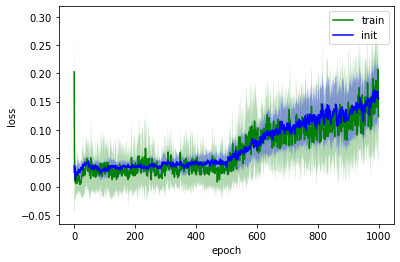

In [58]:
NNplt.plotNN_shifted([T5_Facc_train,T5_Facc_test_init],\
                    labels = ['train', 'init'],\
                    colors = ['green', 'blue'],\
                    shift = 0)
